In [1]:
import sys
!{sys.executable} -m pip install gitpython
!{sys.executable} -m pip install pyvis
from pathlib import Path
from collections import defaultdict

import networkx as nx
import matplotlib.pyplot as plt

# all the needed imports
import os
import sys
import re


from git import Repo

# ──────────────────────────────────────────────────────────────────────────────
# Helpers: module names & imports
# ──────────────────────────────────────────────────────────────────────────────

def module_name_from_file_path(fp: str) -> str:
    p = Path(fp)
    parts = list(p.parts)
    idx = parts.index("zeeguu")
    mod = parts[idx:]
    mod[-1] = mod[-1].replace(".py", "")
    return ".".join(mod)

def imports_from_file(fp: str) -> list[str]:
    imps = set()
    for line in open(fp, encoding="utf8"):
        line = line.strip()
        if line.startswith("import "):
            imps.add(line.split()[1])
        elif line.startswith("from "):
            imps.add(line.split()[1])
    return list(imps)


In [2]:
cwd = os.getcwd()
print(cwd)

/Users/christianlauridsen/Documents/ITU/MSc/semester-2/Software-Architecture/architectural-reconstruction


In [5]:
def build_raw_graph(code_root: Path) -> nx.DiGraph:
    G = nx.DiGraph()
    for py in code_root.rglob("*.py"):
        src = module_name_from_file_path(str(py))
        if not src.startswith("zeeguu.core"):
            continue
        G.add_node(src)
        for tgt in imports_from_file(str(py)):
            if tgt.startswith("zeeguu.core"):
                G.add_node(tgt)
                G.add_edge(src, tgt)
    return G

# Example usage: adjust the path to your project root

CODE_ROOT = Path(cwd+"/content/zeeguu-api/zeeguu/core")
print(f"Code root: {CODE_ROOT}")
rawG = build_raw_graph(CODE_ROOT)
print(f"Raw graph: {rawG.number_of_nodes()} nodes, {rawG.number_of_edges()} edges")


Code root: /Users/christianlauridsen/Documents/ITU/MSc/semester-2/Software-Architecture/architectural-reconstruction/content/zeeguu-api/zeeguu/core
Raw graph: 246 nodes, 620 edges


In [6]:
def top_level_module(mod: str, depth: int = 3) -> str:
    parts = mod.split(".")
    return ".".join(parts[:depth])

def build_weighted_graph(G: nx.DiGraph,
                         depth: int = 3,
                         min_weight: int = 2) -> nx.DiGraph:
    counts = defaultdict(int)
    for u, v in G.edges():
        su = top_level_module(u, depth)
        sv = top_level_module(v, depth)
        if su == sv:
            continue
        if "exercises" in su or "exercises" in sv:
            continue
        if "test" in su or "test" in sv:
            continue
        counts[(su, sv)] += 1

    H = nx.DiGraph()
    for (su, sv), w in counts.items():
        if w >= min_weight:
            H.add_edge(su, sv, weight=w)

    # drop isolates
    for n in list(H.nodes()):
        if H.degree(n) == 0:
            H.remove_node(n)

    return H

weightedG = build_weighted_graph(rawG, depth=3, min_weight=2)
print(f"Weighted & pruned: {weightedG.number_of_nodes()} nodes, {weightedG.number_of_edges()} edges")


Weighted & pruned: 18 nodes, 30 edges


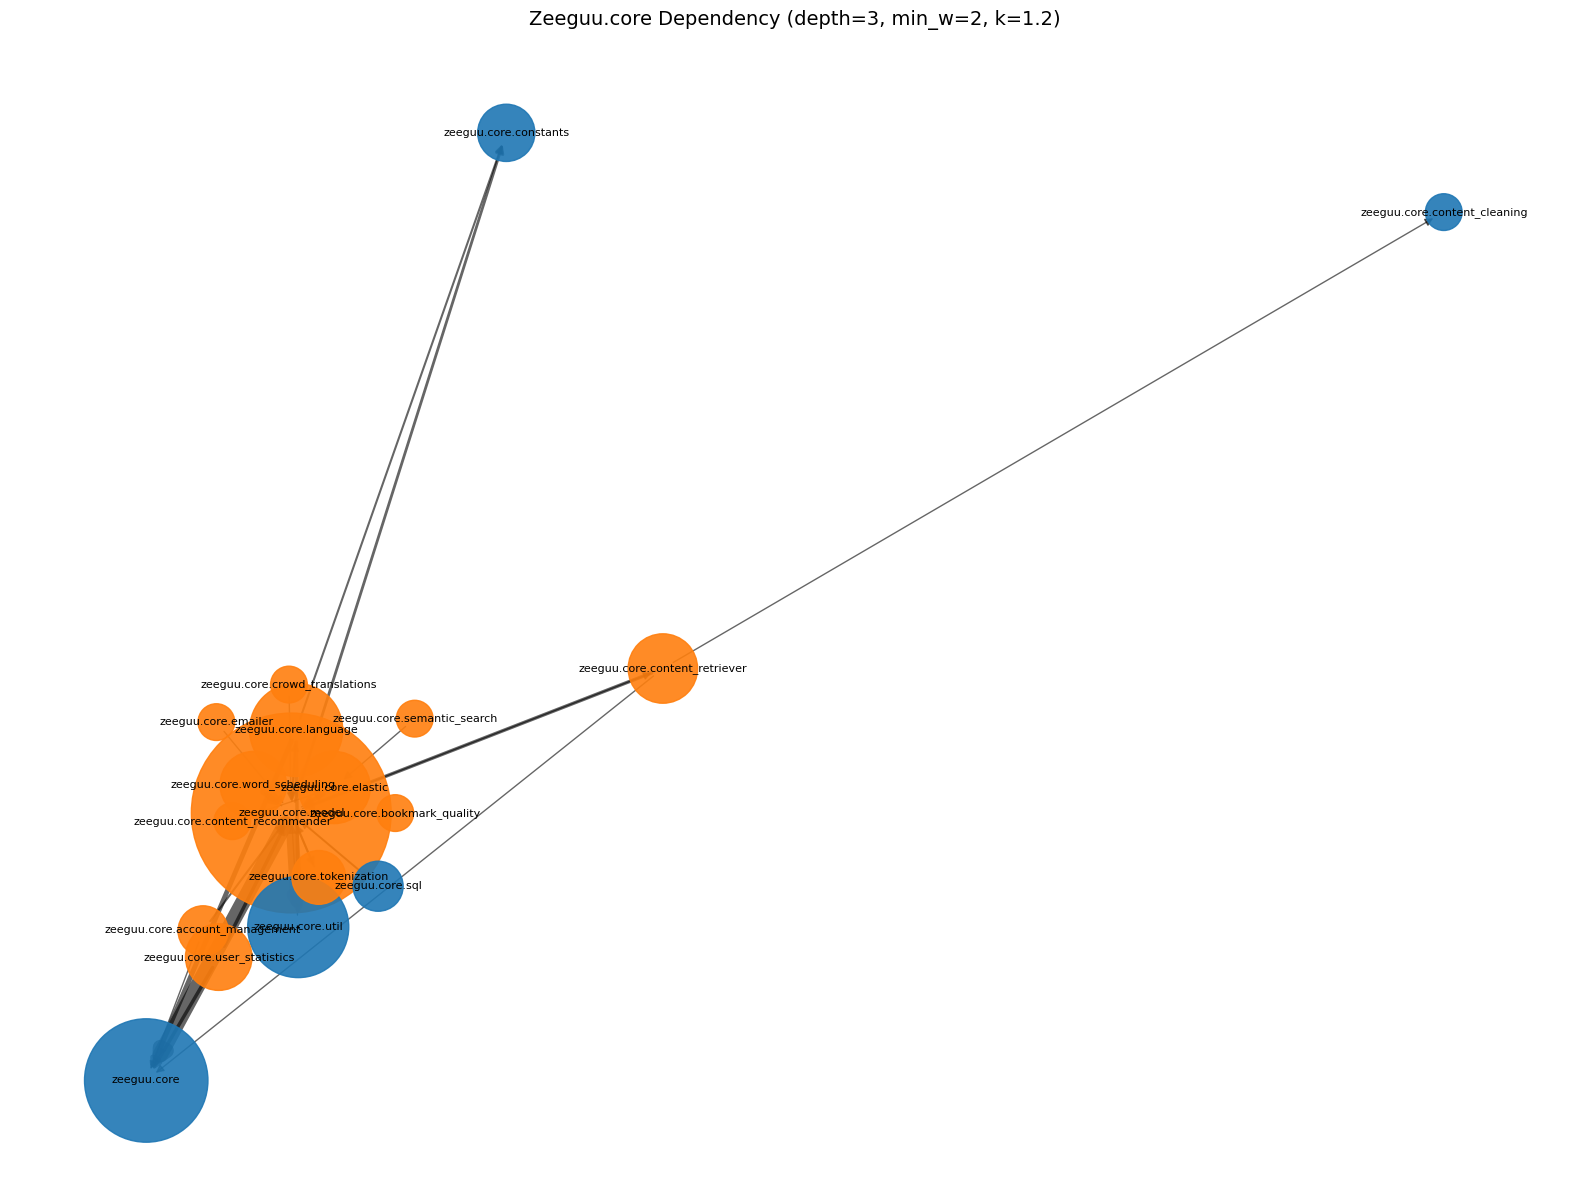

In [7]:
def draw_graph(G: nx.DiGraph, figsize=(14,10), k=1.0, iterations=200):
    pos = nx.spring_layout(G, k=k, iterations=iterations)

    # style
    node_sizes, node_colors = [], []
    for n in G.nodes():
        indeg = G.in_degree(n, weight="weight")
        outdeg = G.out_degree(n, weight="weight")
        tot = indeg + outdeg
        node_sizes.append(300 + 200 * tot)
        node_colors.append("C0" if indeg > outdeg else "C1")

    edge_widths = [max(1.0, d["weight"] / 2) for _, _, d in G.edges(data=True)]

    plt.figure(figsize=figsize)
    nx.draw_networkx_nodes(G, pos,
                           node_size=node_sizes,
                           node_color=node_colors,
                           alpha=0.9)
    nx.draw_networkx_edges(G, pos,
                           width=edge_widths,
                           alpha=0.6,
                           arrowsize=12)
    nx.draw_networkx_labels(G, pos,
                            font_size=8)
    plt.title(f"Zeeguu.core Dependency (depth=3, min_w=2, k={k})", fontsize=14)
    plt.axis("off")
    plt.tight_layout()
    plt.show()

# Finally, render it:
draw_graph(weightedG, figsize=(16,12), k=1.2, iterations=300)


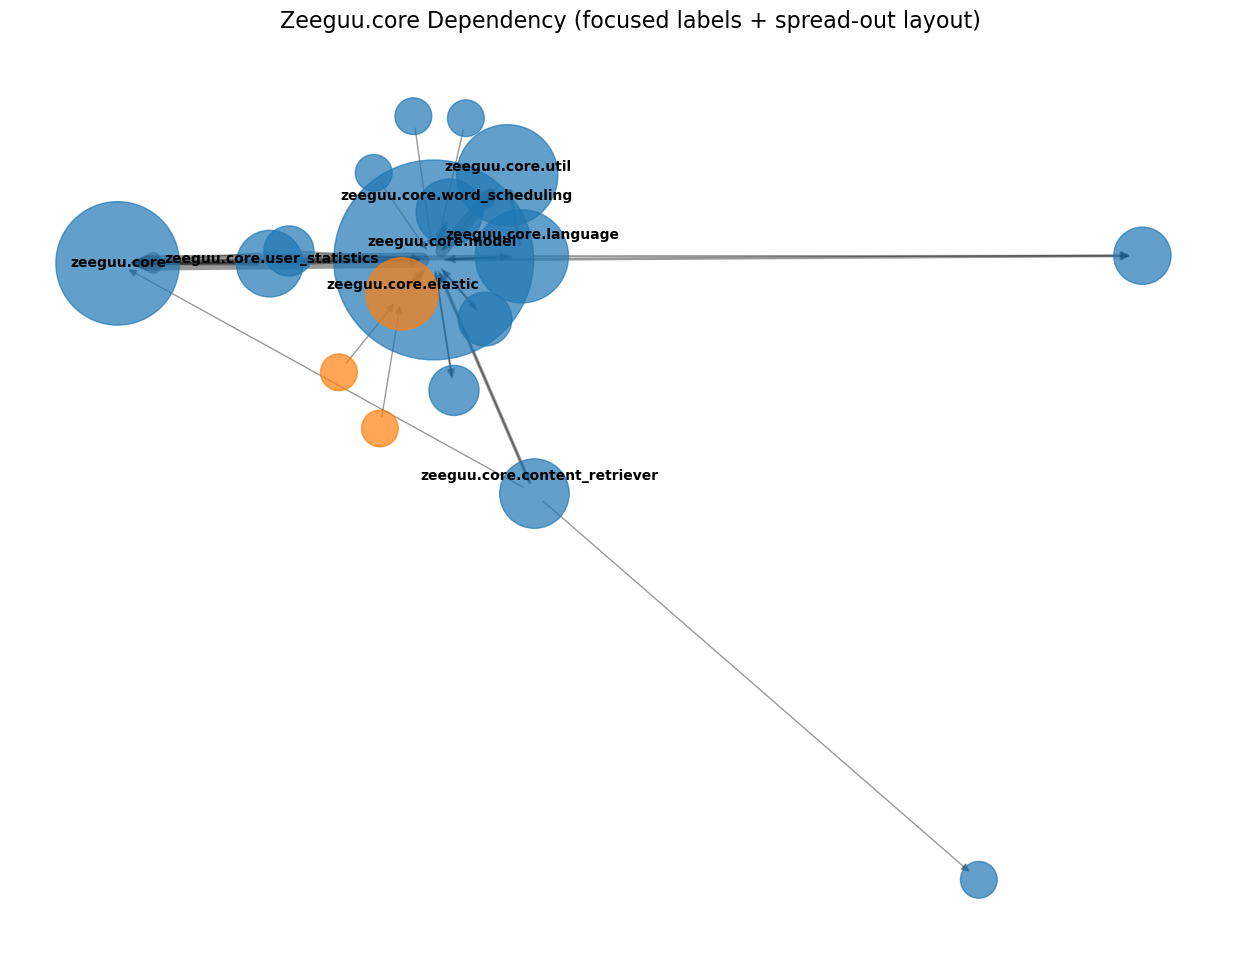

In [28]:
import random
from networkx.algorithms import community

# 1) pick k & iterations for maximum spread
pos = nx.spring_layout(weightedG, k=2.5, iterations=500)

# 2) pick top hubs to label
deg = {n: weightedG.in_degree(n, weight="weight") + weightedG.out_degree(n, weight="weight")
       for n in weightedG.nodes()}
top_nodes = set(sorted(deg, key=lambda n: deg[n], reverse=True)[:8])

# 3) community color‐coding (optional)
comm = next(community.girvan_newman(weightedG))
cluster_map = {n: idx for idx, group in enumerate(comm) for n in group}
node_colors = [f"C{cluster_map[n] % 10}" for n in weightedG.nodes()]

# 4) draw
plt.figure(figsize=(16,12))
nx.draw_networkx_nodes(weightedG, pos,
                       node_size=[300+200*deg[n] for n in weightedG.nodes()],
                       node_color=node_colors,
                       alpha=0.7)
nx.draw_networkx_edges(weightedG, pos,
                       width=[max(1, d["weight"]/2) for *_, d in weightedG.edges(data=True)],
                       alpha=0.4,
                       arrowsize=12)

# 5) jittered labels for only the top modules
labels = {n: n for n in top_nodes}
label_pos = {n: (pos[n][0] + 0.02*random.random(),
                 pos[n][1] + 0.02*random.random())
             for n in top_nodes}
nx.draw_networkx_labels(weightedG, label_pos,
                        labels=labels,
                        font_size=10,
                        font_weight="bold")

plt.title("Zeeguu.core Dependency (focused labels + spread-out layout)", fontsize=16)
plt.axis("off")
plt.show()


In [10]:
from pyvis.network import Network

# `weightedG` is your pruned+aggregated nx.DiGraph
net = Network(
    height="800px", width="100%",
    bgcolor="#ffffff", font_color="black",
    notebook=True, directed=True, cdn_resources='in_line'
)

# add nodes, size by degree
for n in weightedG.nodes():
    tot = weightedG.in_degree(n, weight="weight") + weightedG.out_degree(n, weight="weight")
    net.add_node(n, 
                 label=n,        # label shown on hover
                 title=f"{n}<br>in:{weightedG.in_degree(n,weight='weight')} out:{weightedG.out_degree(n,weight='weight')}",
                 value=tot,      # node size
                 physics=True)

# add edges, width by weight
for u, v, w in weightedG.edges(data="weight"):
    net.add_edge(u, v, value=w)

# tune physics so nodes spread out
net.repulsion(node_distance=200, central_gravity=0.3)

# show inline in Jupyter
net.show("zeeguu_core.html")


zeeguu_core.html


In [22]:
from pathlib import Path
from collections import defaultdict

import networkx as nx
from pyvis.network import Network
from IPython.display import HTML, display

# 1) CONFIG — point here at your project root
PROJECT_ROOT = Path(cwd+"/content/zeeguu-api")
print(f"Project root: {PROJECT_ROOT}")

# 2) Helpers to turn paths into module names
def module_name(fp: Path) -> str:
    # e.g. /…/zeeguu-api/zeeguu/core/foo.py → zeeguu.core.foo
    rel = fp.relative_to(PROJECT_ROOT)
    parts = rel.with_suffix("").parts
    return ".".join(parts)

def imports_from_file(fp: Path) -> list[str]:
    imps = set()
    for line in fp.open(encoding="utf-8"):
        line = line.strip()
        if line.startswith("import "):
            imps.add(line.split()[1])
        elif line.startswith("from "):
            imps.add(line.split()[1])
    return list(imps)

# # 3) Build raw graph across the whole project
# G = nx.DiGraph()
# for py in PROJECT_ROOT.rglob("*.py"):
#     src = module_name(py)
#     G.add_node(src)
#     for tgt in imports_from_file(py):
#         # only keep imports that actually map to your project
#         if any((PROJECT_ROOT / tgt.replace(".", "/")).with_suffix(".py").exists()
#                 for _ in [None]):
#             G.add_edge(src, tgt)

# 3) Build raw graph across the whole project (fixed)
G = nx.DiGraph()

for py in PROJECT_ROOT.rglob("*.py"):
    src = module_name(py)
    G.add_node(src)

    for tgt in imports_from_file(py):

        # 1) skip empty or top‐level imports
        if not tgt or tgt.startswith("."):
            continue

        parts = tgt.split(".")
        # 2) build candidate paths under PROJECT_ROOT
        file_candidate     = PROJECT_ROOT.joinpath(*parts).with_suffix(".py")
        package_candidate  = PROJECT_ROOT.joinpath(*parts, "__init__.py")

        # 3) if either exists, it’s an internal module
        if file_candidate.exists() or package_candidate.exists():
            G.add_node(tgt)
            G.add_edge(src, tgt)


# 4) Aggregate & weight at depth=2 (e.g. zeeguu.core → zeeguu.core)
def top_level(m: str, depth=2):
    return ".".join(m.split(".")[:depth])

counts = defaultdict(int)
for u, v in G.edges():
    pu, pv = top_level(u), top_level(v)
    if pu != pv:
        counts[(pu, pv)] += 1

H = nx.DiGraph()
for (pu, pv), w in counts.items():
    H.add_edge(pu, pv, weight=w)

# 5) Visualize inline with PyVis
net = Network(
    height="600px", width="100%",
    notebook=True, directed=True,
    cdn_resources="in_line",
    bgcolor="#ffffff", font_color="black"
)
# add nodes
for n in H.nodes():
    size = H.in_degree(n, weight="weight") + H.out_degree(n, weight="weight")
    net.add_node(n, label=n, title=f"{n}\nimports: {size}", value=size)
# add edges
for u, v, w in H.edges(data="weight"):
    net.add_edge(u, v, value=w, title=f"weight={w}")

net.repulsion(node_distance=300, central_gravity=0.2)
# writes to disk at the given path
net.save_graph("zeeguu_dependencies.html")
# —or—
net.write_html("zeeguu_dependencies.html")
# —or using the usual show method which also writes—
net.show("zeeguu_dependencies.html")


# net.repulsion(node_distance=200, central_gravity=0.2)
# html = net.generate_html()
# display(HTML(html))


Project root: /Users/christianlauridsen/Documents/ITU/MSc/semester-2/Software-Architecture/architectural-reconstruction/content/zeeguu-api
zeeguu_dependencies.html


In [27]:
from collections import defaultdict

# choose depth=1 or 2
DEPTH = 2  

# 1) bucket every raw edge (u→v) into its top-level parent of given depth
counts = defaultdict(int)
for u, v in G.edges():
    pu = ".".join(u.split(".")[:DEPTH])
    pv = ".".join(v.split(".")[:DEPTH])
    if pu != pv:
        counts[(pu, pv)] += 1

# 2) build a new digraph on those top modules
H_top = nx.DiGraph()
for (pu, pv), w in counts.items():
    H_top.add_edge(pu, pv, weight=w)

# (optional) prune any super-light edges, e.g. w < 2:
H_top = nx.DiGraph(
    (u, v, d) for u, v, d in H_top.edges(data=True) if d["weight"] >= 2
)

# 3) render with PyVis just as you did for H
from pyvis.network import Network
from IPython.display import HTML, display

net = Network(
    height="1000px", width="100%",
    notebook=True, directed=True,
    cdn_resources="in_line",
    bgcolor="#ffffff", font_color="black"
)
for n in H_top.nodes():
    size = H_top.in_degree(n, weight="weight") + H_top.out_degree(n, weight="weight")
    net.add_node(n, label=n, title=f"{n}\nimports: {size}", value=size)
for u, v, w in H_top.edges(data="weight"):
    net.add_edge(u, v, value=w, title=f"weight={w}")
net.repulsion(node_distance=300, central_gravity=0.2)

#display(HTML(net.generate_html()))
net.show("zeeguu_dependencies_top.html")

zeeguu_dependencies_top.html
